# Importing Modules

In [311]:
import re
import pandas as pd
import numpy as np
from numpy import linalg as LA
import csv
from nltk.tokenize import word_tokenize
import warnings
warnings.filterwarnings(action = 'ignore') 
import gensim
from gensim.models import Word2Vec

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt
%matplotlib inline

# Importing and Processing Data

In [312]:
data=[]
#read the MenuItem csv file
with open('MenuItem.csv') as csvfile:
    csv_reader=csv.reader(csvfile, delimiter=',')
    next(csv_reader) #skip the header of the file
    for row in csv_reader:
        menu_lower=row[1].lower() #make them all lowercase
        menu_long=re.sub(r'[^a-zA-Z]','',menu_lower) #keep only letters
        # tokenize the sentence into words
        temp=[]
        for i in word_tokenize(row[1]):
            menu_lower=i.lower() #make them all lowercase
            menu_item=re.sub(r'[^a-zA-Z]','',menu_lower) #keep only letters
            if menu_item!='':
                temp.append(menu_item)
        data.append(temp)

# Training an Embedding Model

In [313]:
# Create CBOW model
model1 = gensim.models.Word2Vec(data, min_count = 1,vector_size = 100, window = 5)

In [314]:
#create a vector for each menu item by averaging its word vectors
def vector_avg(data,model):
    avg_v = []
    for items in data:
        zero_v = np.zeros(model.vector_size)
        vectors = []
        for item in items:
            if item in model.wv:
                try:
                    vectors.append(model.wv[item])
                except KeyError:
                    continue
        if vectors:
            vectors = np.asarray(vectors)
            avg_vec = vectors.mean(axis=0)
            avg_v.append(avg_vec)
        else:
            avg_v.append(zero_vector)
    return avg_v
    
vectorized_items = np.array(vector_avg(data, model=model1))  

# Clustering & Evaluating (K-Means)

In [315]:
#use PCA for dimensionality reduction 
pca=PCA(2)
df=pca.fit_transform(vectorized_items)

def k_means_adjust(cluster_n,df):
    #initialize the class object
    k_means = KMeans(n_clusters=cluster_n, init='random',n_init=10, max_iter=300, tol=1e-04, random_state=0)
    #predict the labels of clusters
    label=k_means.fit_predict(df)
    #k_means_cluster_centers = k_means.cluster_centers_
    score = silhouette_score(df, label, metric='euclidean')
    return k_means,label,score

#using the Silhouette Score as  quantitative metrics to find a better num for num of cluster
score_init=[]
cluster_n=[]
for i in range(2,20):
    cluster_n.append(i)
    k_means,label,score=k_means_adjust(i,df)
    score_init.append(score)
        
print(score_init)
print(cluster_n)

[0.56767315, 0.5298555, 0.52778316, 0.5197722, 0.52922994, 0.52194804, 0.5049698, 0.51166534, 0.5076928, 0.5017737, 0.5036742, 0.495894, 0.4905995, 0.48970056, 0.48450214, 0.4742138, 0.47361523, 0.47038716]
[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]


In [316]:
#cluster_n=2 has the highest Silhouetter Score and 3 has the second to highest
#as dividing food items into 2 did not make lots of sense after trying, use cluster num = 3
k_means,label,score=k_means_adjust(3,df)
print('The num of cluster chosen by comparing Silhouette Score is: ',3)
print('Silhouetter Score: %.3f' % score)

#create a dataframe that includes the 2D vector, label, restaurant name, and its food item
df_final=pd.DataFrame(df, columns = ['x','y'])
df_final['Label']=label
items=pd.read_csv('MenuItem.csv')
df_final['Restaurant Name']=items['Restaurant Name']
df_final['Food Item']=items['Original food Item']
df_final.to_csv('Clustering.csv') #save dataframe as csv file
df_final.head(10)

The num of cluster chosen by comparing Silhouette Score is:  3
Silhouetter Score: 0.530


,x,y,Label,Restaurant Name,Food Item
0,-0.008276,0.001821,0,Coffee Time,Garden Vegetable Sandwich
1,-0.105049,0.000549,0,HoSan,Roasted Seaweed Snack
2,-0.496825,-0.009990,2,Weight Watchers,Muffins
3,-0.211174,-0.000917,2,Natural Sea,"Albacore Tuna, Solid White"
4,0.180231,0.005192,1,World of Beer,Caesar Salad with Grilled Flat Iron Steak
5,0.212904,-0.004448,1,Chick-fil-A,"Honey Mustard Sauce, 8 oz (Catering)"
6,-0.200337,0.000710,2,Tai Pei,Pork Potstickers
7,-0.222731,0.005123,2,Port of Subs,Top Deck Meat & Cheese Champion - 20-25 Guests *
8,-0.260242,-0.000729,2,YoCream,Plain
9,0.035699,-0.011869,0,Blimpie,"Sprite Zero, 28 oz"


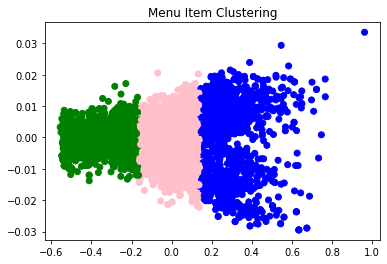

In [317]:
#visualize the clusters
colors=[]
for i in df_final['Label']:
    if i==0:
        colors.append('pink')
    if i==1:
        colors.append('blue')
    if i==2:
        colors.append('green')
plt.scatter(df_final['x'],df_final['y'],marker='o',c = colors)
plt.title('Menu Item Clustering')
plt.show()

# Analysis
Cluster 0: Includes many dressing, soup, chicken, small bites

Cluster 1: Contains many sandwiches, tacos, drinks, bread, pizza

Cluster 2: Contains many sweets and snacks